In [1]:
# ===============================================================
# Basic Libraries
# ===============================================================
import numpy as np
import pandas as pd
import pyarrow as pa 


# ===============================================================
# Machine Learning Libraries
# ===============================================================

## Gradient Boosting & SHAP
import xgboost as xgb
from xgboost import XGBClassifier
import catboost as cb
import lightgbm as lgb
import shap


# Supervised Learning Algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Clustering Algorithm
from sklearn.cluster import KMeans

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, KBinsDiscretizer

# Model Calibration
from sklearn.calibration import CalibratedClassifierCV

# Metrics and Evaluation
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay, accuracy_score, 
                             roc_auc_score, confusion_matrix, log_loss)

## SDV Metadata
from sdv.metadata import SingleTableMetadata

# ===============================================================
# Data Visualization
# ===============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Plot setup
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10, 5)

# ===============================================================
# Deep Learning (Neural Networks)
# ===============================================================

## TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Embedding, Flatten, Dense
from keras.models import Model

## PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# ===============================================================
# Profiling & Diagnostics
# ===============================================================
from ydata_profiling import ProfileReport
from deepchecks.tabular import Dataset
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ===============================================================
# Optional: Version Checks (Uncomment if needed)
# ===============================================================
# print(f"Numpy: {np.__version__}")
# print(f"Pandas: {pd.__version__}")
# print(f"TensorFlow: {tf.__version__}")
# print(f"PyTorch: {torch.__version__}")

 
 

 

 



2025-02-18 13:44:48.330830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739886288.398412    4391 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739886288.422761    4391 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 13:44:48.575844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Get Data

In [2]:
 

# Load datasets
df_customer_churn_demographics = pd.read_csv("data/Telco_customer_churn_demographics.csv")
df_customer_churn_location = pd.read_csv("data/Telco_customer_churn_location.csv")
df_customer_churn_population = pd.read_csv("data/Telco_customer_churn_population.csv")
df_customer_churn_services = pd.read_csv("data/Telco_customer_churn_services.csv")
df_customer_churn_status = pd.read_csv("data/Telco_customer_churn_status.csv")
df_customer_churn = pd.read_csv("data/Telco_customer_churn.csv")


#print(df_customer_churn.columns)

df_customer_churn.drop(columns=['Count', "Gender", "Senior Citizen", "Dependents", "Country", 
                                "State", "City", "Zip Code", "Lat Long", "Latitude",
                                "Longitude",  "Phone Service", "Multiple Lines", "Internet Service",
                                "Online Security", "Online Backup", "Streaming TV", "Streaming Movies",
                                "Contract", "Paperless Billing", "Payment Method", "Total Charges",
                                "CLTV", "Churn Value", "Churn Score", "Churn Label", "Churn Reason"], inplace=True)

# Drop duplicate "Count" columns from each dataset except the first one
df_customer_churn_location = df_customer_churn_location.drop(columns=["Count"])
df_customer_churn_services = df_customer_churn_services.drop(columns=["Count","Quarter"])
df_customer_churn_status = df_customer_churn_status.drop(columns=["Count"])

# Step 1: Merge datasets using 'Customer ID'
df_combined = df_customer_churn_demographics.merge(df_customer_churn_location, on="Customer ID", how="left") \
                                            .merge(df_customer_churn_services, on="Customer ID", how="left") \
                                            .merge(df_customer_churn_status, on="Customer ID", how="left") \
                                            .merge(df_customer_churn, left_on="Customer ID", right_on="CustomerID", how="left")

df_customer_churn_population = df_customer_churn_population.rename(columns={"ID": "Population ID"})  # Rename ID to avoid confusion
 
# Step 2: Merge population dataset using 'Zip Code'
df0 = df_combined.merge(df_customer_churn_population, on="Zip Code", how="left")

# Check final dataset shape
print("Final dataset shape:", df0.shape)

# Display first few rows
df0.to_csv("customer_churn_org.csv")
df0.columns


Final dataset shape: (7043, 60)


Index(['Customer ID', 'Count', 'Gender', 'Age', 'Under 30', 'Senior Citizen',
       'Married', 'Dependents', 'Number of Dependents', 'Country', 'State',
       'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude',
       'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 'Offer',
       'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Quarter', 'Satisfaction Score', 'Customer Status',
       'Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Category',
       'Churn Reason', 'CustomerID', 'Part

In [3]:

def remove_columns_with_zeros_or_nulls(df, nan_threshold=0.5, zero_threshold=0.5):
    # Calculate the percentage of NaN values in each column
    nan_percentage = df.isna().mean()

    # Calculate the percentage of zero values in each column
    zero_percentage = (df == 0).mean()

    # Identify columns with NaN or zero values exceeding the thresholds
    columns_to_drop = nan_percentage[nan_percentage > nan_threshold].index.union(
        zero_percentage[zero_percentage > zero_threshold].index
    )

    # Drop the identified columns
    df_cleaned = df.drop(columns=columns_to_drop)

    return df_cleaned, columns_to_drop


def corr_cols_to_drop(df,  min_threshold=0.4, max_threshold=0.95, step=0.05):     

    df_corr = df.copy()   

    #Fetch columns of object type
    categorical_cols = df_corr.select_dtypes(include=['object']).columns

    # Apply Label Encoding to all string/object columns
    label_encoders = {}  # Store encoders for consistency
    for col in categorical_cols:
        le = LabelEncoder()
        df_corr[col] = le.fit_transform(df_corr[col])
        label_encoders[col] = le  # Store for inverse transform if needed

    # scaler = StandardScaler()
    # df_corr_scaled = pd.DataFrame(scaler.fit_transform(df_corr), columns=df_corr.columns)
    corr_matrix= df_corr.corr().abs()


    #Find optimal threshold
    thresholds = np.arange(min_threshold, max_threshold, step)
    num_features = []
     
    for threshold in thresholds:
        to_drop = set()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > threshold:
                    to_drop.add(corr_matrix.columns[i])
        
        num_features.append(len(df.columns) - len(to_drop))

    # Plot threshold vs number of remaining features
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, num_features, marker='o', linestyle='-')
    plt.xlabel("Correlation Threshold")
    plt.ylabel("Number of Remaining Features")
    plt.title("Optimal Threshold Selection")
    plt.grid()
    plt.show()

    #Get the best threshold
    diffs = np.diff(num_features)  # Compute the drop rate
       
    # Find the index of the lowest value in the drop rate
    min_diff_idx = np.argmin(diffs)
    print(diffs)  
    # Get the thrshold value of that index
    optimal_threshold = thresholds[min_diff_idx]


    threshold = optimal_threshold
    print("Optimal Threshold is: ", threshold)

    # Find pairs of highly correlated features (e.g., correlation > 0.95)
    cols_to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):         
            if corr_matrix.iloc[i, j] > threshold:  # High correlation threshold
                cols_to_drop.add(corr_matrix.columns[j]) # can drop the i or j 

    return cols_to_drop

     
    
    



Pre-Processing

zero null cols:  Index(['Churn Category', 'Churn Reason', 'Churn Value', 'Number of Dependents',
       'Number of Referrals', 'Offer', 'Total Extra Data Charges',
       'Total Refunds'],
      dtype='object')


/tmp/ipykernel_4391/4150614220.py:30: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



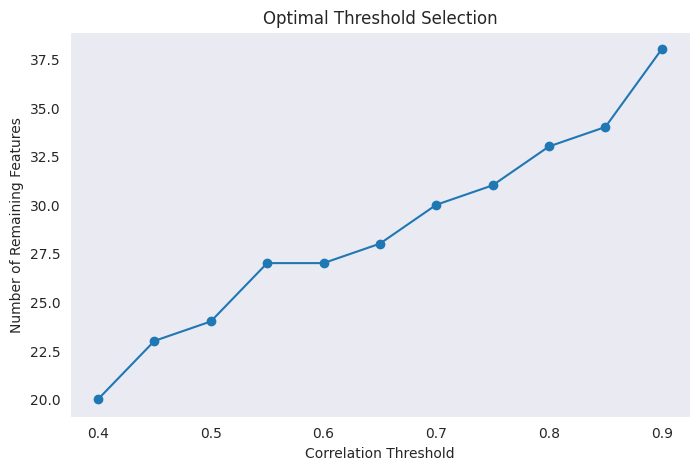

[3 1 3 0 1 2 1 2 1 4]
Optimal Threshold is:  0.55
['gender', 'under_30', 'senior_citizen', 'dependents', 'country', 'state', 'city', 'longitude', 'referred_a_friend', 'phone_service', 'multiple_lines', 'internet_type', 'avg_monthly_gb_download', 'online_security', 'online_backup', 'streaming_music', 'paperless_billing', 'payment_method', 'quarter', 'churn_label', 'cltv', 'tenure_months', 'device_protection', 'tech_support', 'monthly_charges', 'population']


(7043, 26)

In [4]:
df_org = df0.copy()


#Drop columns having 0 or nulls more than 50% 
df_org, zeronullcols = remove_columns_with_zeros_or_nulls(df_org)

print("zero null cols: ", zeronullcols)

# Drop non-relevant columns like IDs - Manual check
exclude_cols = [
    'Customer ID', 'CustomerID', 'Population ID', 'Count',  # ID colums
    'Satisfaction Score', # directly propeortional to churn
    'Tenure in Months', 'Monthly Charge', # repeat columns
    'Customer Status', 'Churn Value', 'Churn Score',
     'Churn Category', 'Churn Reason' # directly propeortional to churn 
]
df_org = df_org.drop(columns=exclude_cols, errors="ignore")

# Remove spaces from all column names
df_org.columns = df_org.columns.str.replace(" ", "_").str.replace("-","_")

# lowercase it
df_org.columns = df_org.columns.str.lower()

# Convert comma-separated numbers to numeric
def convert_numeric_with_commas(series):
    return pd.to_numeric(series.astype(str).str.replace(",", ""), errors="coerce")

for col in df_org.columns:
    if df_org[col].dtype == "object" and df_org[col].str.contains(r"^\d{1,3}(,\d{3})*$", na=False).any():
        df_org[col] = convert_numeric_with_commas(df_org[col])

# imputation
df_org['population'] = df_org['population'].apply(pd.to_numeric, errors='coerce')  # Convert to numeric (handle commas, etc.)
df_org['population'] = df_org['population'].fillna(df_org['population'].median())


#Remove Exact duplicate columns 
df_org = df_org.loc[:, ~df_org.T.duplicated()]  # Remove exact duplicate columns

#Remove highly corr columns
to_drop = corr_cols_to_drop(df_org)
df_org = df_org.drop(columns=to_drop)


df_org.to_csv("customer_churn_preprocessed.csv", index=False)

print(df_org.columns.to_list())
 
df_org.shape

Get Data Types and Cardinality

In [5]:


def infer_data_types_and_cardinality(file_path, sample_size=500):
    """
    Auto-detects data types (binary, categorical, ordinal, continuous, datetime, identifier)
    and classifies cardinality (low, medium, high).
    """

    # Load dataset
    df = pd.read_csv(file_path, low_memory=False)

    # Sample for better inference
    sample_data = df.sample(min(sample_size, len(df)))

      # SDV Schema Detection
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)
    sdv_types = metadata.to_dict()["columns"]  
 
    final_types = {}
    cardinality_info = {}
    #print("col-name--------" "ptype","atype","sdvtype")
    
    for col in df.columns:
        sdv_type = sdv_types[col]["sdtype"] if col in sdv_types else "Unknown"

        series = df[col]
        unique_values = series.dropna().unique()  # Drop NaN and get unique values
        unique_count = len(unique_values)  # Get the number of unique values         
        total_count = len(series.dropna())

        cardinality_ratio = unique_count / total_count  

        refined_type = sdv_type        
        if unique_count == 2:
            refined_type = "binary"

        if cardinality_ratio < 0.1:
            cardinality = "low"
        elif cardinality_ratio < 0.7:
            cardinality = "medium"
        else:
            cardinality = "high"

        # Preserve priority order for type detection
        final_types[col] = (
            refined_type 
        )

        # Store cardinality info
        cardinality_info[col] = cardinality

    # Combine into DataFrame for structured output
    result_df = pd.DataFrame({"Column Name": list(final_types.keys()), 
                              "Data Type Classification": list(final_types.values()), 
                              "Cardinality Classification": list(cardinality_info.values())})

    return result_df

# Example Usage
file_path = "customer_churn_preprocessed.csv"
classification_df = infer_data_types_and_cardinality(file_path)

# Print results in tabular format
print("\n🔹 **Data Type & Cardinality Classification**")
classification_df
print(classification_df.to_string(index=False))
classification_df.to_csv("data_types_and_cardinality.csv")



🔹 **Data Type & Cardinality Classification**
            Column Name Data Type Classification Cardinality Classification
                 gender                   binary                        low
               under_30                   binary                        low
         senior_citizen                   binary                        low
             dependents                   binary                        low
                country              categorical                        low
                  state      administrative_unit                        low
                   city                     city                     medium
              longitude                longitude                     medium
      referred_a_friend                   binary                        low
          phone_service                   binary                        low
         multiple_lines                   binary                        low
          internet_type              categ

Encode the dataset, per the cardinality and data type

In [6]:
df = pd.read_csv("customer_churn_preprocessed.csv") # df_org.copy()

# Load inferred data types and cardinality classification
classification_df = pd.read_csv("data_types_and_cardinality.csv")

# Convert to dictionaries for easy lookup
data_types = classification_df.set_index('Column Name')['Data Type Classification'].to_dict()
cardinality = classification_df.set_index('Column Name')['Cardinality Classification'].to_dict()

# Standardize column names: lowercase, replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(" ", "_")
classification_df["Column Name"] = classification_df["Column Name"].str.lower().str.replace(" ", "_")

# Identify column categories dynamically
numerical_cols = [col for col in df.columns if (data_types.get(col) == 'discrete' or data_types.get(col) == 'continuous')]
categorical_cols = [col for col in df.columns if (data_types.get(col) == 'categorical')]
binary_cols = [col for col in df.columns if data_types.get(col) == 'binary']

# Convert numerical columns
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert binary columns to 0/1 dynamically
for col in binary_cols:
    unique_values = df[col].dropna().unique()
    if len(unique_values) == 2:
        df[col] = df[col].map({unique_values[0]: 0, unique_values[1]: 1})

# Remove binary columns from categorical encoding
categorical_cols = [col for col in categorical_cols if col not in binary_cols]

# Handle categorical encoding based on cardinality
low_cardinality = [col for col in categorical_cols if cardinality.get(col) == 'low']
medium_cardinality = [col for col in categorical_cols if cardinality.get(col) == 'medium']
high_cardinality = [col for col in categorical_cols if cardinality.get(col) == 'high']


if low_cardinality:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int)

    # Keep only non-null values for encoding
    df_non_null = df[low_cardinality].dropna()

    encoded_array = ohe.fit_transform(df_non_null)
    encoded_col_names = [f"{col}_{category}" for col, categories in zip(low_cardinality, ohe.categories_) for category in categories]

    encoded_df = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df_non_null.index)

    # Drop original categorical columns and merge encoded ones (without NaN rows)
    df.drop(columns=low_cardinality, inplace=True)
    df = df.join(encoded_df).fillna(0)

# Apply Frequency Encoding if its a medium Cardinality
for col in medium_cardinality:
    freq_encoding  = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].map(freq_encoding)

# Apply Label Encoding or Ordinal Encoding for high cardinality columns
for col in high_cardinality:
    if df[col].nunique() > 100:        
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    else:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Geospatial Clustering (city, state, postcode)
geo_features = [
    col for col in df.columns if data_types.get(col) in [
        'city', 'administrative_unit', 'state', 'province', 'postcode', 'country', 'country_code', 'region', 'district',
        'latitude', 'longitude', 'location', 'timezone', 'neighborhood', 'postal_code', 'continent', 'suburb'
    ]
]
# Loop through identified geo-related columns
for col in geo_features:
    if df[col].nunique() > 5:
        # Apply Label Encoding for geospatial columns with more than 5 unique values
        le = LabelEncoder()
        df[f"{col}_encoded"] = le.fit_transform(df[col].astype(str))
        df.drop(columns=[col], inplace=True)  # Drop original column after encoding
    else:
        # If fewer unique values, use One-Hot Encoding
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_geo_df = pd.DataFrame(ohe.fit_transform(df[[col]]), columns=ohe.get_feature_names_out([col]))
        df = pd.concat([df, encoded_geo_df], axis=1)
        df.drop(columns=[col], inplace=True)  # Drop original column after encoding

# Normalize Continuous Numerical Columns
if numerical_cols:
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Drop Remaining Non-Numeric Columns
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
df.drop(columns=non_numeric_cols, inplace=True)

# Display dropped columns
dropped_columns = non_numeric_cols
print("Dropped Columns:", dropped_columns)

# Save Processed Dataset
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("-","_")


df.to_csv("customer_churn_encoded.csv", index=False)
print("Final dataset shape:", df.shape)


Dropped Columns: []
Final dataset shape: (7043, 32)


Generate training and testing datasets

In [7]:
# Load preprocessed data

def fetch_train_test_ds(df):    

    # Define target variable
    target_col = "churn_label"  # Modify if the target column is different

    # Separate features (X) and target (y)
    X = df.drop(columns=[target_col])  
    y = df[target_col]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

    Scaler = StandardScaler()
    # X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    # X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


    return X, y, X_train, X_test, y_train, y_test 




## defining a function to print classification report and plot the confusion matrix
def modelPerformance(model, y_pred, y_test, y_prob, title = ""):
    #y_pred = model.predict(test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC-ROC Score:", roc_auc_score(y_test, y_prob))
    print("*"*75)
    print(classification_report(y_test, y_pred, digits=2))
    print("*"*75)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels = ['Remained', 'Churned'])
    disp.plot(cmap='inferno')
    if title:
        disp.ax_.set_title(f"Confusion Matrix for {title}");



Feature Selection Using SHAP

In [81]:
import xgboost as xgb
from xgboost import XGBClassifier

df = pd.read_csv("customer_churn_encoded.csv")
X, y, X_train, X_test, y_train, y_test = fetch_train_test_ds(df)


# Train XGBoost Model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Explain Model with SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Get Mean Absolute SHAP Values for Feature Importance
shap_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": np.abs(shap_values).mean(axis=0)
})

# Sort by Importance
shap_importance = shap_importance.sort_values(by="Importance", ascending=False)

# Select Top Features (Threshold or Top N)
top_n = 20  # Adjust as needed
top_features = shap_importance["Feature"].head(top_n).tolist()

# Keep only top features in df
df = df[top_features + ["churn_label"]]  # Retaining target column

# Save Updated DataFrame
df.to_csv("customer_churn_selected_features.csv", index=False)

# Display Top Important Features
print(f"Top {top_n} Important Features:")
print(shap_importance.head(top_n))

/home/deepavn/AI/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[15:19:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Top 20 Important Features:
                           Feature  Importance
13                   tenure_months    1.232610
3                       dependents    0.650184
14                 monthly_charges    0.606933
26                 tech_support_no    0.473845
29                    city_encoded    0.308542
15                      population    0.292327
30               longitude_encoded    0.273831
12                            cltv    0.242551
7          avg_monthly_gb_download    0.204637
8                  online_security    0.196790
11               paperless_billing    0.188470
21      payment_method_credit_card    0.131638
9                    online_backup    0.106143
20  payment_method_bank_withdrawal    0.095175
10                 streaming_music    0.092879
4                referred_a_friend    0.081639
18               internet_type_dsl    0.081178
17             internet_type_cable    0.077205
19       internet_type_fiber_optic    0.076534
6                   multiple_line

Check Models Performance

Accuracy: 0.8097941802696949
AUC-ROC Score: 0.861290655919812
***************************************************************************
              precision    recall  f1-score   support

           0       0.69      0.52      0.59       374
           1       0.84      0.92      0.88      1035

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

***************************************************************************


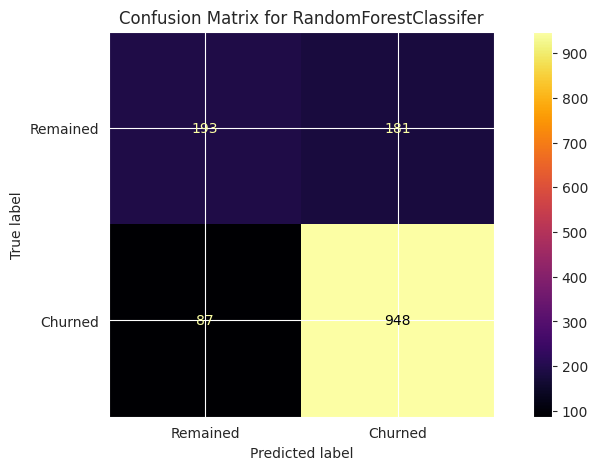

In [82]:
df = pd.read_csv("customer_churn_selected_features.csv")
X, y, X_train, X_test, y_train, y_test = fetch_train_test_ds(df)

# Choose a model (Random Forest as an example)
model_rf = RandomForestClassifier(n_estimators=100, random_state=101, criterion="log_loss")

# Train the model
model_rf.fit(X_train, y_train)

# Predictions
y_pred_rf= model_rf.predict(X_test)
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]  # Probability for AUC-ROC

# Evaluate performance
 
modelPerformance(model_rf,y_pred_rf, y_test, y_prob_rf, "RandomForestClassifer")

Accuracy: 0.7984386089425124
AUC-ROC Score: 0.8422821566044072
***************************************************************************
              precision    recall  f1-score   support

           0       0.64      0.54      0.59       374
           1       0.84      0.89      0.87      1035

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

***************************************************************************


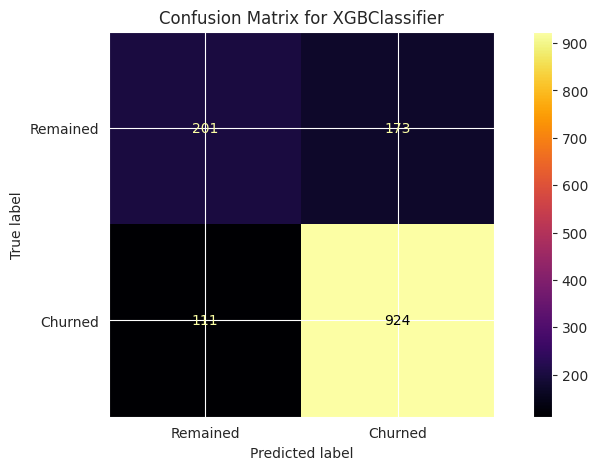

In [83]:
import xgboost as xgb
from xgboost import XGBClassifier

df = pd.read_csv("customer_churn_selected_features.csv")
X, y, X_train, X_test, y_train, y_test = fetch_train_test_ds(df)

# XGBoost Model
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
modelPerformance(xgb_model,y_pred_xgb, y_test, y_prob_xgb, "XGBClassifier")


0:	learn: 0.6867813	total: 6.54ms	remaining: 3.27s
100:	learn: 0.4396756	total: 347ms	remaining: 1.37s
200:	learn: 0.3979027	total: 697ms	remaining: 1.04s
300:	learn: 0.3790655	total: 1.02s	remaining: 677ms
400:	learn: 0.3658049	total: 1.36s	remaining: 335ms
499:	learn: 0.3551305	total: 1.69s	remaining: 0us
Accuracy: 0.8090844570617459
AUC-ROC Score: 0.8718179234803276
***************************************************************************
              precision    recall  f1-score   support

           0       0.69      0.51      0.59       374
           1       0.84      0.92      0.88      1035

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409

***************************************************************************


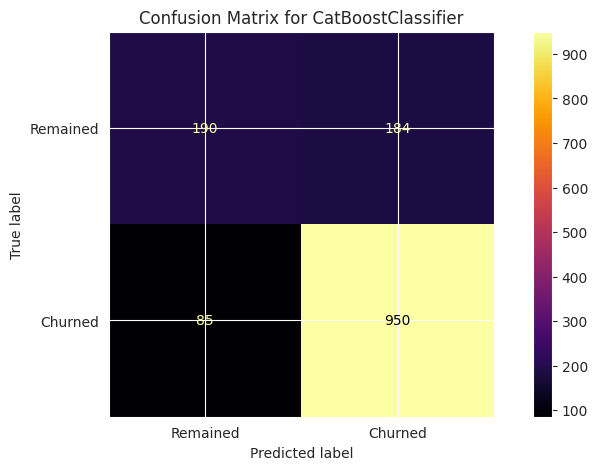

In [84]:
 

# CatBoost Model
cat_model = cb.CatBoostClassifier(iterations=500, learning_rate=0.01, depth=6, verbose=100)

df = pd.read_csv("customer_churn_selected_features.csv")
X, y, X_train, X_test, y_train, y_test = fetch_train_test_ds(df)

# Fit the model
cat_model.fit(X_train, y_train)  # Specify categorical features

# Predictions
y_pred_cat = cat_model.predict(X_test)
y_prob_cat = cat_model.predict_proba(X_test)[:, 1]

# Evaluation
modelPerformance(cat_model, y_pred_cat, y_test, y_prob_cat, "CatBoostClassifier")


In [12]:
# df = pd.read_csv("customer_churn_encoded.csv")
# profile = ProfileReport(df, explorative=True)
# profile.to_notebook_iframe() 


In [85]:
import xgboost as xgb
from xgboost import XGBClassifier
df = pd.read_csv("customer_churn_selected_features.csv")
X, y, X_train, X_test, y_train, y_test = fetch_train_test_ds(df)

# # Train Logistic Regression with Platt Scaling
# lr = LogisticRegression(max_iter=500)
# calibrated_lr = CalibratedClassifierCV(lr, method='sigmoid', cv=5)
# calibrated_lr.fit(X_train_scaled, y_train)

# # Train Random Forest with Isotonic Calibration
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv=5)
# calibrated_rf.fit(X_train_scaled, y_train)

# Train XGBoost Model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Calibrate XGBoost (using Platt Scaling)
calibrated_xgb = CalibratedClassifierCV(xgb_model, method='isotonic', cv=5)
calibrated_xgb.fit(X_train, y_train)

# Train CatBoost Model
cat_model = cb.CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=100, random_state=42)
cat_model.fit(X_train, y_train)

# Calibrate CatBoost (using Isotonic Calibration)
calibrated_cat = CalibratedClassifierCV(cat_model, method='isotonic', cv=5)
calibrated_cat.fit(X_train, y_train)

# Predict churn probabilities
# probabilities_lr = calibrated_lr.predict_proba(X_test_scaled)[:, 1]
# probabilities_rf = calibrated_rf.predict_proba(X_test_scaled)[:, 1]
probabilities_xgb = calibrated_xgb.predict_proba(X_test)[:, 1]
probabilities_cat = calibrated_cat.predict_proba(X_test)[:, 1]

# Evaluate models
# roc_auc_lr = roc_auc_score(y_test, probabilities_lr)
# roc_auc_rf = roc_auc_score(y_test, probabilities_rf)
roc_auc_xgb = roc_auc_score(y_test, probabilities_xgb)
roc_auc_cat = roc_auc_score(y_test, probabilities_cat)

# log_loss_lr = log_loss(y_test, probabilities_lr)
# log_loss_rf = log_loss(y_test, probabilities_rf)
log_loss_xgb = log_loss(y_test, probabilities_xgb)
log_loss_cat = log_loss(y_test, probabilities_cat)

# Print evaluation results
# print(f"Logistic Regression - ROC AUC: {roc_auc_lr:.3f}, Log Loss: {log_loss_lr:.3f}")
# print(f"Random Forest - ROC AUC: {roc_auc_rf:.3f}, Log Loss: {log_loss_rf:.3f}")
print(f"XGBoost - ROC AUC: {roc_auc_xgb:.3f}, Log Loss: {log_loss_xgb:.3f}")
print(f"CatBoost - ROC AUC: {roc_auc_cat:.3f}, Log Loss: {log_loss_cat:.3f}")


0:	learn: 0.6632473	total: 8.03ms	remaining: 4.01s
100:	learn: 0.3537722	total: 391ms	remaining: 1.55s
200:	learn: 0.3136504	total: 761ms	remaining: 1.13s
300:	learn: 0.2794278	total: 1.14s	remaining: 754ms
400:	learn: 0.2517999	total: 1.51s	remaining: 372ms
499:	learn: 0.2262791	total: 1.87s	remaining: 0us
0:	learn: 0.6631338	total: 4.7ms	remaining: 2.35s
100:	learn: 0.3472397	total: 354ms	remaining: 1.4s
200:	learn: 0.3013746	total: 681ms	remaining: 1.01s
300:	learn: 0.2628490	total: 1.01s	remaining: 672ms
400:	learn: 0.2306428	total: 1.36s	remaining: 335ms
499:	learn: 0.2035392	total: 1.69s	remaining: 0us
0:	learn: 0.6623680	total: 4.59ms	remaining: 2.29s
100:	learn: 0.3501498	total: 347ms	remaining: 1.37s
200:	learn: 0.3064311	total: 663ms	remaining: 986ms
300:	learn: 0.2690937	total: 993ms	remaining: 656ms
400:	learn: 0.2359453	total: 1.32s	remaining: 327ms
499:	learn: 0.2098286	total: 1.64s	remaining: 0us
0:	learn: 0.6625920	total: 11.1ms	remaining: 5.53s
100:	learn: 0.3432798	to

In [14]:
# import shap

# # Extract the first calibrated model
# base_model = calibrated_cat.calibrated_classifiers_[0].estimator

# # Create SHAP explainer
# explainer = shap.Explainer(base_model, X_train_scaled)
# shap_values = explainer(X_test_scaled)

# # SHAP Summary Plot
# shap.summary_plot(shap_values, X_test_scaled)


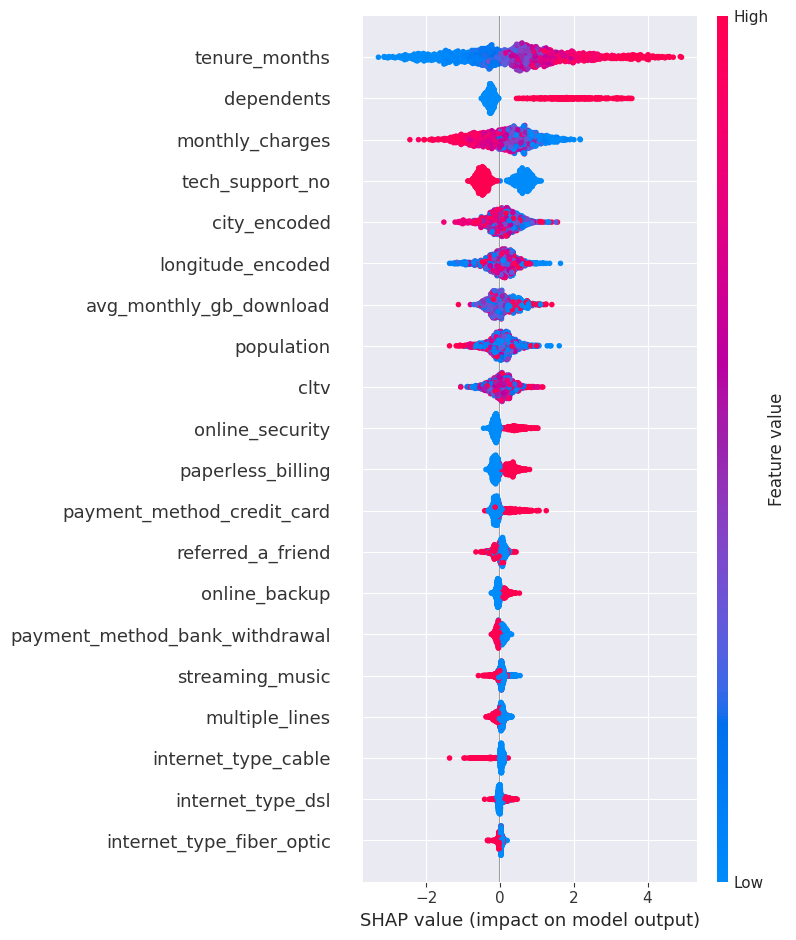

In [86]:

df = pd.read_csv("customer_churn_selected_features.csv")
X, y, X_train, X_test, y_train, y_test = fetch_train_test_ds(df)

# Train XGBoost model
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)

# SHAP Explainer for XGBoost
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)


0:	learn: 0.6805056	total: 3.59ms	remaining: 1.79s
100:	learn: 0.3966309	total: 362ms	remaining: 1.43s
200:	learn: 0.3646845	total: 721ms	remaining: 1.07s
300:	learn: 0.3447693	total: 1.09s	remaining: 724ms
400:	learn: 0.3286665	total: 1.47s	remaining: 364ms
499:	learn: 0.3138476	total: 1.86s	remaining: 0us


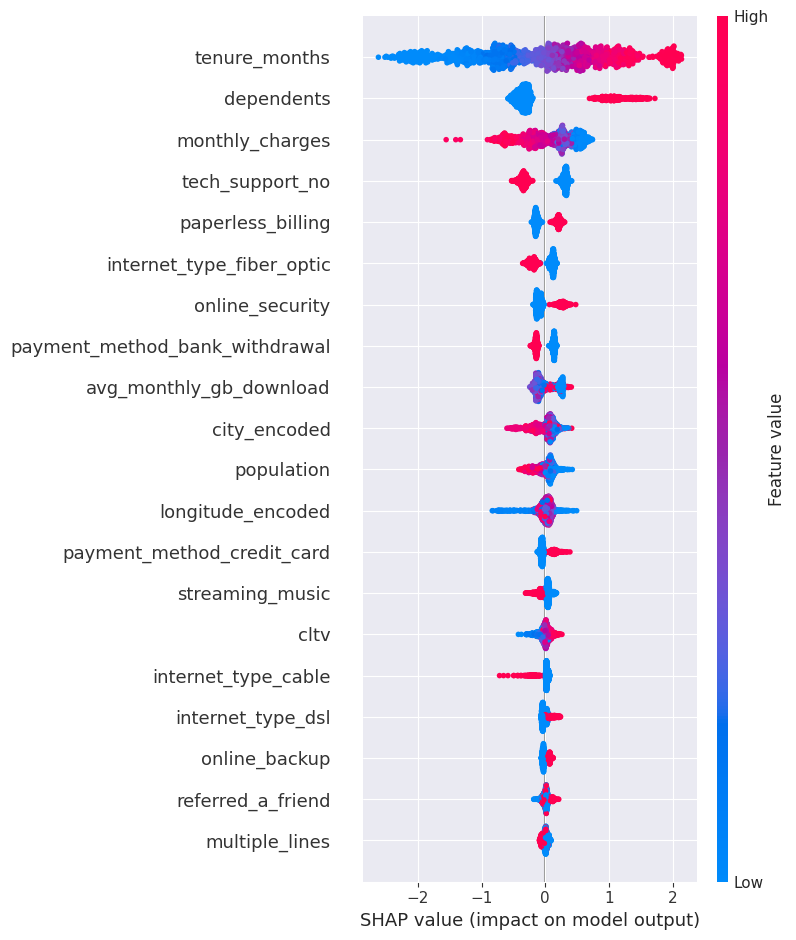

In [87]:

df = pd.read_csv("customer_churn_selected_features.csv")
X, y, X_train, X_test, y_train, y_test = fetch_train_test_ds(df)

# Train Catboost model
cat_model = cb.CatBoostClassifier(iterations=500, learning_rate=0.02, depth=6, verbose=100)
cat_model.fit(X_train, y_train)

# SHAP Explainer for Catboost
explainer = shap.Explainer(cat_model)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

In [17]:
# df_profile = pd.read_csv("customer_churn_encoded.csv")
# profile = ProfileReport(df, explorative=True)
# profile.to_notebook_iframe() 